# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

# Part 0 Initialization

## 0.0 Import necessary module

In [1]:
from __future__ import absolute_import, division, print_function

# Import necessary modules
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

import os
import cv2 as cv2
import matplotlib.mlab
from collections import defaultdict
from functools import reduce

from skimage import measure
from scipy.optimize import curve_fit
from scipy.signal import medfilt
from scipy.stats import norm

from skimage.segmentation import clear_border

from skimage.measure import label, regionprops
from scipy.ndimage.measurements import center_of_mass

from operator import itemgetter

import pandas as pd

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

In [8]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

## 0.2 Load data

In [9]:
# Load images 
os.listdir('../data/project-data/')
data_dir = '../data/project-data/'

img_dict = dict()
gt_dict = dict()
img_types = ['train', 'validation', 'test']

for img_type in img_types:
    
    # Get file names
    with open(f'{data_dir}/{img_type}.txt', 'r') as f:
        
        filenames = f.read().split('\n')
    
    # Get images
    img_dict[img_type] = skimage.io.imread_collection([f'{data_dir}/images/{img_type}/{img_name}.jpg'
                                                      for img_name in filenames])
    
    # Get groundtruth
    gt_dict[img_type] = [parse_file(f'{data_dir}/annotations/{img_type}/{img_name}.xml')
                        for img_name in filenames]
    

# 1. Thresholding

The 1.1 - 1.4 sections explain some of decision choices in this method.

Please jump directly to 1.5 for evaluation.

In [51]:
# Get histogram of pixel values
k = 11
gray_img = skimage.color.rgb2gray(img_dict['train'][k]) * 255

In [47]:
threshold = [86, 86, 95]

## 1.1 Preprocess by smoothing

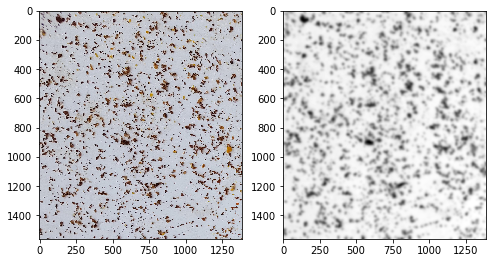

In [58]:
from scipy.signal import wiener

from scipy.ndimage.filters import gaussian_filter

tmp_median_smoothed = gaussian_filter(gray_img, 8)

fig = plt.figure(figsize = (8, 10))
ax = fig.add_subplot(121)
ax.imshow(img_dict['train'][k])

ax = fig.add_subplot(122)
ax.imshow(tmp_median_smoothed, cmap = 'gray')

fig.savefig('./smoothing.png')

Obviously smoothing degrades the img so we insist with original one.

## 1.2 Label objects

1.2.1 Label objects using measure.label method provided in skimage module

1.2.2 Get features of detected objs including size and bounding rectangle

### 1.2.1 Conduct primitive labeling

In [13]:
# Get labels
labels = measure.label(bi_img)

In [14]:
# Illustrate labels
print(f'number of objects found are {np.max(labels) + 1}')

number of objects found are 2435


The above count show that primitive labeling cannot distinguish vorroa objs from the others since we only have tens of vorroas in an image generally.

### 1.2.2 Get size and bounding rectangle of each object

In [15]:
# Get size of detected objs
obj_sizes = dict(zip(*np.unique(labels, return_counts = True)))

# Build list of pixels for each obj
obj_pixels_alt = defaultdict(list)

for i in range(labels.shape[0]):
    
    for j in range(labels.shape[1]):
        
        obj_pixels_alt[labels[i][j]].append((i, j))

# Compute the covering rect of detected objs
obj_bbox = {k : np.asarray(cv2.boundingRect(np.asarray(obj_pixels_alt[k])))[[1, 0, 3, 2]]
            for k, v in obj_pixels_alt.items()}

# Get the area of bounding rectangle for each detected obj
obj_bbox_size = {k : obj_bbox[k][2] * obj_bbox[k][3] for k in obj_bbox.keys()}

Text(0.5, 1.0, 'Log-Log histogram of size of detected objs')

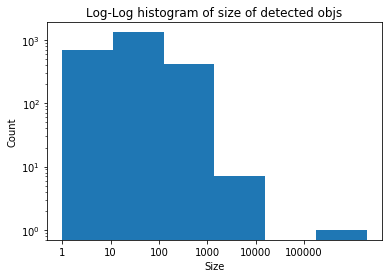

In [16]:
# Visualize the size distribution of objects
plt.hist(np.log10(list(obj_sizes.values())),
          bins = 6,
        log = True)
_ = plt.xticks(np.arange(6), [f'{10 ** s}' for s in np.arange(6)])
plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Log-Log histogram of size of detected objs')

From the distribution of size one can observe that there are two types of objs detected that should not be regarded as vorroas:

1. objects with extreme large size: these objects may be background or some unrelated objects

2. objects with extreme small size: these objects may be measurement noise

The above findings motivate us to find the thresholds for filtering objects by size.

## 1.3 Filter objects by size

1. Set thresholds by checking the distribution of vorroa's sizes in training data
2. Filter objects that are likely to be vorroa using aforementioned thresholds

### 1.3.1 Find distribution of size of vorroa

In [17]:
# Check avg vorroa size
avg_size_list = []

for i, img in enumerate(np.random.choice(gt_dict['train'], size = 500, replace = False)):
    
    # Add avg of vorroa size in this img to list
    try:
        
        avg_size_list += reduce(lambda l, item: l + [item['bbox'][2] * item['bbox'][3]],
                                   img,
                                    [])
    
    except:
        
        pass

In [18]:
# Get mean and var of size of vorroa obj
size_mean = np.mean(avg_size_list)

size_std = np.std(avg_size_list)

Text(0.5, 1.0, 'Groundtruth vorroa size distribution')

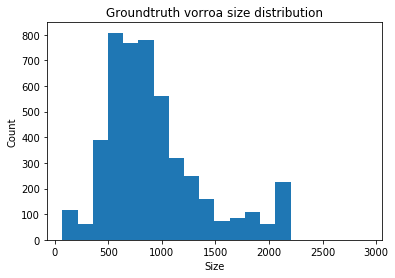

In [19]:
# Visualize the vorroa size distribution
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(avg_size_list, bins = 20)
ax.set_xlabel('Size')
ax.set_ylabel('Count')
ax.set_title('Groundtruth vorroa size distribution')

Assume that vorroa are located pairwisely independent,
Chebshev inequility indicates that by taking the size thrs to be $\mu + 3\sigma$,
we can capture about $90\%$ of vorroa objects.

So we may set the upper bound of size of an valid vorroa obj to be that value.

In [20]:
# Set upper size threshold
up_size_thrs = size_mean + 3 * size_std

By heuristics we may set the lower bound of size of an valid vorroa to be 350.

In [21]:
# Set lower size threshold
low_size_thrs = np.float64(350)

### 1.3.2 Filter detected obj based on size thresholds found.

In [22]:
# Filter the detected obj by size_thrs
obj_mask = np.where((list(obj_sizes.values()) > low_size_thrs) *\
                    (list(obj_sizes.values()) < up_size_thrs),
                    1,
                    0)

In [23]:
# Get the filtered objs
obj_bbox_values = list(obj_bbox.values())
filtered_objs = np.asarray([obj_bbox_values[i] for i in range(len(obj_mask)) if obj_mask[i]])

Text(0.5, 1.0, 'Groundtruth: Red   Detected: Steelblue')

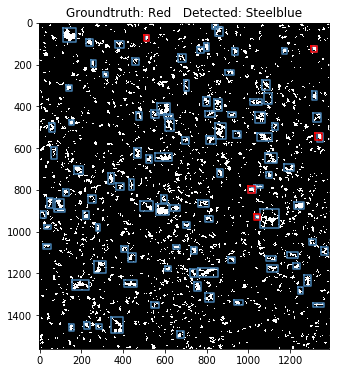

In [27]:
# Visualize the filtered objs on the binary figure
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)

# Show img
ax.imshow(bi_img, cmap = 'gray')

# Show detected objs
for obj in filtered_objs:
    
    ax.plot([obj[0], obj[0] + obj[2], obj[0] + obj[2], obj[0], obj[0]],
           [obj[1], obj[1], obj[1] + obj[3], obj[1] + obj[3], obj[1]],
           c = 'steelblue')

# Show ground truth obj
gt_objs = [item['bbox'] for item in gt_dict['train'][k]]

for obj in gt_objs:
    
    ax.plot([obj[0], obj[0] + obj[2], obj[0] + obj[2], obj[0], obj[0]],
       [obj[1], obj[1], obj[1] + obj[3], obj[1] + obj[3], obj[1]],
       c = 'red')

ax.set_title('Groundtruth: Red   Detected: Steelblue')

The results is still pretty noisy.
By observation we found out that there is possibility to filter based on density of the detected objects.

$density(obj) = \frac{\# pixels\ with\ value\ 1}{size\ of\ window}$

In [42]:
def plot_window(window, ax = None, c = None, label = None):
    """
    Plot the window
    Params: window: coordinates and length of the window
            ax: axes to plot 
            c: color
            label: label
    Return: 
    """
    
    if c == None:
        
        c = 'steelblue'
        
    if label == None:
        
        label = ''
        
    if ax != None:
        
        # Handle the case where axes to plot specified
        ax.plot([window[0], window[0] + window[2], window[0] + window[2], window[0], window[0]],
               [window[1], window[1], window[1] + window[3], window[1] + window[3], window[1]],
               c = c,
               label = label)
    
    else:
        
        # Handle the case where axes to plot not specified
        plt.plot([window[0], window[0] + window[2], window[0] + window[2], window[0], window[0]],
               [window[1], window[1], window[1] + window[3], window[1] + window[3], window[1]],
               c = c,
               label = label)

In [49]:
# Get the density for each filtered_obj
# Notice that the first coordinate actually means x0, thus is on the 2nd dimension
density = list(map(lambda window: np.sum(bi_img[window[1] : window[1] + window[3],
                                               window[0] : window[0] + window[2]]) /\
                                   (window[2] * window[3]),
                  filtered_objs))

## 1.4 Define evaluation function

Evaluate our segmentation results by calculating precision, recall and f1 score.

In [25]:
def calculate_IoU(a, b):
    """
    Calculate the IoU of a and b
    Params: a: (a.x, a.y, a.w, a.h)
            b: (b.x, b.y, b.w, b.h)
    Return: IoU(a, b)
    """
    
    # Calculate intersection area
    dx = min(a[0] + a[2], b[0] + b[2]) - max(a[0], b[0])
    dy = min(a[1] + a[3], b[1] + b[3]) - max(a[1], b[1])
    
    # Return zero if no intersection
    if dx <= 0 or dy <= 0:
        return 0
    
    # Set intersection area
    int_area = dx * dy
    
    # Calculate union length
    uni_area = a[2] * a[3] + b[2] * b[3] - int_area
    
    return int_area / uni_area 

In [26]:
def cal_stats(values, thrs, gtl):
    """
    Calculate precision, recall and f1_score for given thrshold
    Param: values : np.array
           thrs : double
           gtl : length of ground truth
    Return: (prec, recall, f1_score)
    """
    
    # Get boolean judgment for values using thrs
    results = np.asarray(values) > thrs
    
    # Get prec
    prec = np.sum(results) / len(values)
    
    # Get rec
    rec = np.sum(results) / gtl
    
    # Get f1_score
    f1 = 2 * prec * rec / (prec + rec)
    
    return (prec, rec, f1)

## 1.5 Output results
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

The approach we decide to use for defining the threshold is the following:

1) let's look at the varroa boxes for each images of the training set

2) appling a threshold for each of these boxes in order to distinguish foreground from background

3) keep all the threshold ( 3 threshold for the three channels) and average them

4) the lower bound for the final threshold would be [0,0,0] and the upper bound is the average threshold found in point 3)

Another important consideration should be done for the varroa's area. In fact, as we select the varroa's boxes from each training image and applying the threhsold, we label the regions found and we took the second biggest region as a representation of the varroa's area. The final area is the average +/- 2 standard deviation of the total areas.

The below constants were obtained from the methods described in the slides. 

For simplicity we just hard code them here.

In [975]:
THRESHOLD = [86, 86, 95]
AREA_MEAN = 329
AREA_STD = 166

In [ ]:
# get the parent directory
data_base_path = os.path.join(os.pardir, 'data') 
#initialize this list to save all the train images
image_list = []

#uploas the 800 images of the train set
for filename in sorted(glob.glob(data_base_path+'/project-data/images/train/*.jpg')):# put sorted otheriwse the order is arbitrary!!
    im=cv2.imread(filename)
    image_list.append(im)

In [ ]:
#uploas the 50 images of the test set
image_test_list=[]
for filename in sorted(glob.glob(data_base_path+'/project-data/images/test/*.jpg')[0:50]):# put sorted otheriwse the order is arbitrary!!
    im=cv2.imread(filename)
    image_test_list.append(im)

In [ ]:
#extract the labels for the test and train set:
annotations_xmls=[parse_file(filename) for filename in sorted(glob.glob(data_base_path+'/project-data/annotations/train/*.xml'))]
annotations_test_xmls=[parse_file(filename) for filename in sorted(glob.glob(data_base_path+'/project-data/annotations/test/*.xml'))]

In [ ]:
def calculate_value_of_interest(image, x,y,width,height):
    min_value,max_value=0,0
    threshold=[]
    area=0
    #define the area of interest
    image_corr=image[y:y+height,x:x+width,:]
    #threshold for each of thre channel
    for j in range(3):
        threshold.append(find_threshold(image_corr[:,:,j]))
    lower_color_bounds = np.array([0, 0, 0],dtype = "uint8")
    upper_color_bounds = np.asarray(threshold).astype('uint8')

    #label the region found by the thresholding method and took the second biggest as representing the varroa
    mask = cv2.inRange(image_corr,lower_color_bounds,upper_color_bounds )
    label_image = label(mask)
    
    area=np.sort(np.bincount(label_image.flat))[::-1][1]
    
    return threshold,area

In [ ]:
threshold=[]
area=[]
area_box=[]
ground_truth={}

for i,annotations in enumerate(annotations_xmls):
    true_values=[]
   
    for anno in annotations:
            
            #labels
            true_values.append([anno['bbox'][0],anno['bbox'][1],anno['bbox'][0]+anno['bbox'][2],anno['bbox'][1]+anno['bbox'][3]])
            #varroa's boxes area
            area_box.append([anno['bbox'][2]*anno['bbox'][3]])
            #threshold and area of the varroa
            thresh,area_=calculate_value_of_interest(image_list[i],anno['bbox'][0],anno['bbox'][1],anno['bbox'][2],anno['bbox'][3])
            
            threshold.append(thresh)
            area.append(area_)
    #dictionatu containing all the labels     
    ground_truth[str(i)]=[]
    ground_truth[str(i)].append(true_values)
        

resulting_threshold=np.mean(threshold,axis=0).round()  
area_final=np.mean(area).round()
print('the resulting threshold is  {} +/- {} '.format(resulting_threshold,np.std(threshold,axis=0).round()))
print('the resulting area is  {} +/- {} '.format(area_final,np.std(area).round()))

In [ ]:
#function that defines the threshold for each image of the training set: otsu method was choosen
def find_threshold(image):
    thresh_min = threshold_otsu(image)
    
    return thresh_min

In [991]:
def detect_by_segmentation(image_test_list, resulting_threshold = THRESHOLD, 
                           area_final = AREA_MEAN, area = AREA_STD):
    '''
    Input: One single imagevia catona
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    lower_color_bounds=np.array([0,0,0],dtype='uint8')
    upper_color_bounds = np.asarray(resulting_threshold).astype('uint8')
    
    
    prediction=[]
   
    
    #applying th thresholding
    mask = cv2.inRange(image_test_list,lower_color_bounds,upper_color_bounds )
    #remove artifacts connected to image border--> a lot of false positive at the border
    cleared = mask.copy()
    clear_border(cleared)

    # label image regions
    label_image = label(cleared)
    borders = np.logical_xor(mask, cleared)
    label_image[borders] = -1
    
    

    for region in regionprops(label_image):
   
        #area should be higher than the average area -std of the area and less than the average area +std
        if (region.area >= area_final-np.std(area).round()) & (region.area <= area_final+2*area):
      
            minr, minc, maxr, maxc = region.bbox
            prediction.append([minc,minr,maxc,maxr])

    return np.asarray(prediction)

Report results.

In [993]:
#function evaluating the intersection over union:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = (xB - xA) * (yB - yA)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return round(iou,1)

In [994]:
#function evaluating if two images intersect :
def verify_intersection(real_value,prediction):
    if ((real_value[0]<prediction[2]) & (prediction[0]<real_value[2]) & (real_value[3]>prediction[1]) & (real_value[1]<prediction[3])):
        return True

In [1000]:
#evaluating the I0U for all the 50 test_images:
threshold=0.3
tp,fp,fn=0,0,0

for i in range( len(ground_test_truth.keys())):
    print('nb of image:{}'.format(i))
    df=pd.DataFrame(index=range(len(ground_test_truth[str(i)][0])), columns=range(len(pred[str(i)][0])))
    for  k,real_value in enumerate(ground_test_truth[str(i)][0]):

        for j,prediction in enumerate(pred[str(i)][0]):#for each prediction let's calculate the IoU respect to each target

                if verify_intersection(real_value,prediction) :
                    iou=bb_intersection_over_union(prediction,real_value)
                    df.loc[k,j]=iou
                else :

                    df.loc[k,j]=0
     #counting the number of true positive, false postive nd false negative               
    tp+=np.sum(df.max(axis=1)>=threshold)
    fp+=np.sum(df.max(axis=0)<threshold)
    fn+=np.sum(df.max(axis=1)<threshold)


In [997]:
print('true positive:{} ,false positive:{} ,false negative:{}'.format(tp,fp,fn))

true positive:363 ,false positive:2776 ,false negative:209


In [998]:
print('precision',tp/(tp+fp))
print('recall',tp/(tp+fn))
print('F1',( 2*tp/(tp+fn) * tp/(tp+fp) )/(tp/(tp+fp)+tp/(tp+fn)))

precision 0.11564192417967506
recall 0.6346153846153846
F1 0.19563459983831852


# 2 Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [23]:
# Define some constants
gray = [122.9, 125.4, 143.2]

window_height, window_width = 32, 32

## 2.1 Prepare data

In [76]:
# Get test imgs
test_imgs = img_dict['test']

# Get test groundtruth
test_gt = gt_dict['test']

# Get number of ground truth objs
gtl = reduce(lambda current_length, next_item: current_length + len(next_item), test_gt, 0)

# Initialize iou_scores
iou_scores_all = []

# Loop through all img to detect vorroas
for i, img in enumerate(test_imgs):
    
    # Get detected objs
    detected_objs = detect_by_segmentation(img)
    
    # Get groundtruth
    gt_img = [item['bbox'] for item in test_gt[i]]
    
    # Compute max IoU score for each detected obj
    iou_scores = [np.max([calculate_IoU(detected, gt) for gt in gt_img]) if len(gt_img) > 0 else 0 \
                  for detected in detected_objs]
    
    # Append results for this img to total results
    iou_scores_all += iou_scores

# Calculating statistics
prec, rec, f1 = cal_stats(iou_scores_all, thrs = 0.3, gtl = gtl)

In [80]:
print(f'Precision: {prec}\nRecall: {rec}\nF1: {f1}')

Precision: 0.09903121636167922
Recall: 0.4742268041237113
F1: 0.163846838824577


From the vorroa size distribution, one may convince himself that setting the sliding window with length 48 and width 48 sufficies to detect all feasible vorroas.

The step of window cropping scheme results in the low recall of adaptive crop labeling algorithm.

Now let's try on manually building positive windows.

The histogram illustrates that window size of 32 * 32 captures the majority of vorroas

Now let's boost each groundtruth window to size of 32 * 32


In [29]:
window_height, window_width = 32, 32

In [114]:
def expand_window(img, gt_windows, window_width = window_width, window_height = window_height):
    """
    Expand window of img to (window_width, window_height)
    Params: img: (n, m, 3) array
            gt_windows: list of windows
            window_width: width
            window_height: height
    Return: list of expanded windows
    """

    # Get height and width of img
    height, width, _ = img.shape
    results = []
    
    for window in gt_windows:

        # Get x dimension increment to make
        delta_x = window_width - window[2]

        # Get y dimension increment to make
        delta_y = window_height - window[3]

        if window[0] < (delta_x // 2):
            # Handle the case where left space is not enough

            x_new = 0

        elif window[0] + window[2] + (delta_x - delta_x // 2) >= width:
            # Handle the case where right space is not enough

            x_new = width - 1 - window_width

        else:
            # Handle normal case

            x_new = window[0] - delta_x // 2

        if window[1] < (delta_y // 2):
            # Handle the case where upper space is not enough

            y_new = 0

        elif window[1] + window[3] + (delta_y - delta_y // 2) >= height:
            # Handle the case where lower space is not enough

            y_new = height - 1 - window_width

        else:

            y_new = window[1] - delta_y // 2

        results.append([x_new, y_new, window_width, window_height])
    
    return results

In [30]:
def construct_training_crops(img, windows, 
                             window_width = window_width,
                             window_height = window_height,
                             negative_increment = 5):
    """
    Construct training crops from img with specific window height and width
    Return: [positive_crops, negative_crops]
    """
    
    """ Build positive samples by expanding the gt window to required shape """
    expanded_windows = expand_window(img, windows)

    vorroa_crops = [img[window[1] : window[1] + window[3], window[0] : window[0] + window[2]] \
                   for window in expanded_windows]

    """ Build negative samples by random sampling """

    # Define sample size for each img
    negative_sample_size = len(vorroa_crops) + negative_increment

    # Sample starting point
    negative_x = np.random.choice(img.shape[1] - window_width, negative_sample_size)
    negative_y = np.random.choice(img.shape[0] - window_height, negative_sample_size)

    # Construct windows
    negative_windows = list(zip(negative_x,\
                                negative_y,\
                                np.ones(len(negative_x)).astype(np.int) * window_width,\
                                np.ones(len(negative_x)).astype(np.int) * window_height))

    # Filter windows overlapping vorroa windows
    if len(vorroa_crops) > 0:
        
        negative_windows = list(filter(lambda window: np.max([calculate_IoU(window, gt_window)\
                                           for gt_window in expanded_windows]) < 0.3,
                   negative_windows))

    # Get the content of negative window
    negative_crops = [img[window[1] : window[1] + window[3], window[0] : window[0] + window[2]] \
                   for window in negative_windows]

    negative_crops = np.asarray(negative_crops)
    
    if len(vorroa_crops) == 0:
        
        return negative_crops, [0] * len(negative_crops)
    
    else:
        
        return np.concatenate([vorroa_crops, negative_crops]), np.concatenate([[1] * len(vorroa_crops),
                                                                          [0] * len(negative_crops)])

In [116]:
crops, labels = [], []

In [117]:
for i in range(len(gt_dict['train'])):
    
    # Get img
    img = img_dict['train'][i]
    
    # Get gt_windows
    gt_windows = gt_dict['train'][i]
    
    gt_windows = [item['bbox'] for item in gt_windows]
    
    # Get crops and labels
    current_crops, current_labels = construct_training_crops(img, gt_windows)
    
    # Update crops and labels
    try:
        
        crops = np.concatenate([crops, current_crops], axis = 0)
    
    except:
        
        crops = current_crops
    
    labels = np.concatenate([labels, current_labels])

KeyboardInterrupt: 

In [ ]:
# Store data to file
np.save('window_crops', crops)

np.save('labels', labels)

Please load them from local file directly once created.

In [ ]:
window_crops = np.load('window_crops.npy')

labels = np.load('labels.npy')

## 2.2 Generate feature

In [17]:
def find_fourier_descriptor(img, l = 1):
    """
    Find the l-th fourier descriptor for given img
    Params: img: np.array
            l: int
    Return: (x, y)
    """

    # Get test img
    test_img = img

    # Convert gray img to binary img
    thrs = (test_img < 100) * 255
    thrs = thrs.astype(np.uint8)

    # Find contour
    contours, hier = cv2.findContours(thrs, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # Return origin if no contours were found
    if len(contours) == 0:
        
        return 0, 0
    
    # For simplicity we only take the longest contour
    contour = sorted(contours, key = lambda x: len(x))[-1]

    # Normalization
    contour = contour.reshape(-1, 2).T

    contour -= np.mean(contour, axis = 1).astype(np.int).reshape(2, 1)

    # Get length of contour
    N = len(contour[0])

    # Get real part of contour
    real = contour[0]

    # Get imaginary part of contour
    imginary = contour[1] * 1j

    # Build Fourier descriptor for the contour

    # First Fourier descriptor
    f = np.sum((real + imginary) * np.exp(-2 * np.pi * l * 1j / N * np.arange(N)))

    # Second Fourier descriptor
    # f2 = np.sum((real + imginary) * np.exp(2 * np.pi * 1j / N * np.arange(0, 2 * N, 2)))

    # Return real and imaginary part of f1
    return f.real, f.imag

In [14]:
def generate_features(img):
    """
    Generate feature vectors of |f1|, |f2|, avg and std of R, G, B colors from cropped img
    Params: img
    Return: features
    """
    
    # Convert img to gray scale
    gray_img = skimage.color.rgb2gray(img) * 255
    
    # Get first fourier descriptor
    f1_norm = np.sqrt(np.sum(np.square(find_fourier_descriptor(gray_img, 1))))
    
    # Get second fourier descriptor
    f2_norm = np.sqrt(np.sum(np.square(find_fourier_descriptor(gray_img, 2))))
    
    # Get avg and std of R, G, B channel
    avg = np.mean(img, axis = (0, 1))
    
    std = np.std(img, axis = (0, 1))

    return np.concatenate([[f1_norm, f2_norm], avg, std])

In [15]:
def generate_test_features(img, window_height = 32, window_width = 32, stride = 16):
    """
    Generate features and positions for a full test img
    Params: test img
    Return: list of features, list of bouding box
    """
    
    # Initialize features list and position list
    features = []
    positions = []
    
    # Loop through all boxes to generate features
    for x in range(0, img.shape[1] - window_width, stride):
        
        for y in range(0, img.shape[0] - window_height, stride):
            
            # Generate features for current crop
            feature = generate_features(img[y : y + window_height, x : x + window_width])
            
            # Add feature to features list
            features.append(feature)
            
            # Add bounding box to positions list
            positions.append([x, y, window_width, window_height])
            
    return features, positions

In [16]:
def get_false_positive(pred_positive_windows, gt_windows, img, thrs = 0.2):
    """
    Get false positive in training set for iterative training
    @Params: pred_positive_windows: windows that are predicted to be positives
             gt_windows: ground truth windows
             img: img generateing the results
             thrs: threshold for filtering false positive
    @Return: false_positive features, 
    """

    # Get predicted windows
    pred_windows = pred_positive_windows

    # Get false positive windows
    if len(gt_windows) != 0:
        false_positive_windows = pred_windows[[np.max([calculate_IoU(pred, gt)\
                                                       for gt in gt_windows]) < thrs\
                                               for pred in pred_windows]]
    else:
        false_positive_windows = pred_windows

    # Conduct non-max suppression 
    false_positive_windows = non_max_suppression_fast(false_positive_windows, 0.25)
    
    # Construct features for false positive
    false_positive_features = [generate_features(img[window[1] : window[1] + window[3],
                                                    window[0] : window[0] + window[2]])
                              for window in false_positive_windows]

    # Reshape feature
    false_positive_features = np.concatenate(false_positive_features).reshape(-1, 8)
    
    return false_positive_features

In [12]:
def remove_black(img):
    """
    Remove black stuff in the img
    Params: img
    Return: filtered_img
    """
    
    tmp_img = img.copy()
    
    # Get black and white img for filtering black stuff
    #black_white_img = np.max(tmp_img, axis = 2) < 60

    # Label the black and white img
    labeled_img = measure.label(skimage.color.rgb2gray(tmp_img) * 255 < 100)

    label_counts = dict(zip(*np.unique(labeled_img, return_counts = True)))

    # Get large object index
    large_stuff = np.asarray(list({k: v for k, v in label_counts.items() if v > 1200}))

    # Get black stuff index
    black_stuff = np.asarray(measure.regionprops(labeled_img))[large_stuff - 1]

    for i in range(len(black_stuff)):
        # Get black stuff coords
        black_box = black_stuff[i].coords

        tmp_img[black_box.T[0], black_box.T[1]] = gray
        
    return tmp_img

In [90]:
# Generate features for all training crops
x = np.asarray([generate_features(crop) for crop in window_crops])

## 2.3 Classification

### 2.3.1 Initial training of SVC

In [ ]:
# Build train test split

# Get shuffle permutation
indices = np.random.permutation(len(x))

# Get train and test indices 
train_indices = indices[: int(0.8 * len(indices))]

test_indices = indices[int(0.8 * len(indices)) :]

# Get train and test split
x_train = x[train_indices]

y_train = labels[train_indices]

x_test = x[test_indices]

y_test = labels[test_indices]

crops_test = window_crops[test_indices]

crops_train = window_crops[train_indices]

""" Normalize training and testing data"""

x_mean = np.mean(x_train, axis = 0)

x_std = np.std(x_train, axis = 0)

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

# Build classifier 
svc = SVC(probability = True)

# Train
svc.fit(x_train, y_train)

# Find training prediction
y_train_pred = svc.predict(x_train)

y_train_pred_proba = svc.predict_proba(x_train)

# Find testing prediction
y_test_pred_proba = svc.predict_proba(x_test)

y_test_pred = svc.predict(x_test)

In [ ]:
print(f'Testing accuracy is {np.mean(y_test_pred == y_test)}')
print(f'Testing precision is {precision_score(y_test, y_test_pred)}')
print(f'Testing recall is {recall_score(y_test, y_test_pred)}')
print(f'Testing f1 score is {f1_score(y_test, y_test_pred)}')

In [ ]:
print(f'Training accuracy is {np.mean(y_train_pred == y_train)}')
print(f'Training precision is {precision_score(y_train, y_train_pred)}')
print(f'Training recall is {recall_score(y_train, y_train_pred)}')
print(f'Training f1 score is {f1_score(y_train, y_train_pred)}')

The testing results seems to be acceptable.

Now let's try it on full images.

In [ ]:
# Get train img and label
results = []
for k in range(50):
    
    print(f'Processing {k}')
    # Get full img
    full_img = img_dict['train'][k]

    # Get full groundtruth
    full_gt = gt_dict['train'][k]
    full_gt = np.asarray([item['bbox'] for item in full_gt])
    
    # Generate features and positions for full img
    features, positions = generate_test_features(full_img, 32, 32, 16)
    positions = np.asarray(positions)

    # Normalize full features
    features = (features - x_mean) / x_std

    # Conduct classification on full crops
    y_test_pred = svc.predict(features)

    # Get predict positives windows
    pred_positives = np.where(y_test_pred == 1)[0]
    
    pred_positive_windows = np.asarray(positions[pred_positives])
    
    if len(pred_positives) == 0:
        
        continue
        
    # Get false positive features
    results.append(get_false_positive(pred_positive_windows, full_gt, full_img))

In [ ]:
results = np.concatenate(results)

### 2.3.2 Iterative training

In [ ]:
# Replace negative samples in training set by false positive 
positive_indices = np.where(labels == 1)[0]

x_updated = np.concatenate([x, results])
y_updated = np.asarray(list(labels) + [0] * len(results))

In [ ]:
np.save('x_iterated_train', x_updated)
np.save('y_iterated_train', y_updated)

In [ ]:
x_updated = np.load('x_iterated_train.npy')

In [ ]:
y_updated = np.load('y_iterated_train.npy')

In [ ]:
# Re-train

# Build train test split

# Get shuffle permutation
indices = np.random.permutation(len(x_updated))

# Get train and test indices 
train_indices = indices[: int(0.7 * len(indices))]

test_indices = indices[int(0.7 * len(indices)) :]

# Get train and test split
x_train = x_updated[train_indices]

y_train = y_updated[train_indices]

x_test = x_updated[test_indices]

y_test = y_updated[test_indices]

""" Normalize training and testing data"""

x_mean = np.mean(x_train, axis = 0)

x_std = np.std(x_train, axis = 0)

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

# Build classifier 
svc = SVC(probability = True, class_weight = 'balanced')

# Train
svc.fit(x_train, y_train)

# Find training prediction
y_train_pred = svc.predict(x_train)

y_train_pred_proba = svc.predict_proba(x_train)

# Find testing prediction
y_test_pred_proba = svc.predict_proba(x_test)

y_test_pred = svc.predict(x_test)

In [73]:
tmp_pred = svc.predict(x_train)

In [ ]:
print(f'Training accuracy is {np.mean(y_train_pred == y_train)}')
print(f'Training precision is {precision_score(y_train, y_train_pred)}')
print(f'Training recall is {recall_score(y_train, y_train_pred)}')
print(f'Training f1 score is {f1_score(y_train, y_train_pred)}')

### 2.3.3 Post processing

### 2.3.3.1 Recenter 

In this section we post process by recenter the detected region using center of mass.

It is indeed useful

In [18]:
def recenter(img, windows, window_width = 32, window_height = 32):
    """
    Rencenter windows to centered at centroid of mass
    @Params: img: image where windows reside
             windows: list of windows
    @Return: recentered_windows
    """
    
    recentered_windows = []
    
    for window in windows:
        
        # Get crop
        crop = img[window[1] : window[1] + window[3],
                   window[0] : window[0] + window[2]]
        
        # Get center of mass
        delta_y, delta_x = center_of_mass(skimage.color.rgb2gray(crop) * 255 < 100)
        
        # Continue if no center of mass exists
        if np.isnan(delta_x) or np.isnan(delta_y):
            
            continue
            
        # Get recentered window
        recentered_window = [max(0, window[0] + int(delta_x) - window_width // 2),
                            max(0, window[1] + int(delta_y) - window_height // 2),
                            window_width,
                            window_height]
        
        recentered_windows.append(recentered_window)
    
    return recentered_windows

### 2.3.3.2 Non max suppression

In [19]:
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2] + x1
    y2 = boxes[:,3] + y1

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

## 2.4 Evaluations

### 2.4.1 Define classifier

Please run through the pipeline above to generate data if not already stored locally.

In [2]:
# Load training data
x = np.load('x_iterated_train.npy')

y = np.load('y_iterated_train.npy')

In [3]:
x_mean = [151.98404422,  69.60085223, 130.3453316 , 131.64208379,
           131.40098087,  27.23362615,  33.33493116,  35.98291065]

In [4]:
x_std = [202.39797346, 126.81439986,  32.53543573,  35.40300464,
        42.23405531,  16.18141347,  19.39415473,  20.38129124]

In [5]:
# Normalize
x_mean = np.mean(x, axis = 0)

x_std = np.std(x, axis = 0)

# Preprocess 
x = (x - x_mean) / x_std

In [20]:
def detect_by_svc(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    # Get features and positions of crops of img
    features, positions = generate_test_features(img,
                                                 window_height = 32,
                                                 window_width = 32,
                                                stride = 16)
    positions = np.asarray(positions)
    
    # Normalizations
    features = (features - x_mean) / x_std
    
    # Get predictions
    predictions = svc.predict(features)
    
    # Get predicted positive windows
    pred_pos_windows = positions[np.where(predictions == 1)[0]]
    
    # Recenter the windows
    recentered_pos_windows = np.asarray(recenter(img, pred_pos_windows))

    # Non max suppression 
    filtered_pos_windows = non_max_suppression_fast(recentered_pos_windows, 0.05)
    
    return filtered_pos_windows

Training phase

In [7]:
# Train
svc = SVC(probability = True)

svc.fit(x, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Testing phase

In [27]:
# Get test imgs
test_imgs = img_dict['test']

# Get test groundtruth
test_gt = gt_dict['test']

# Get number of ground truth objs
gtl = reduce(lambda current_length, next_item: current_length + len(next_item), test_gt, 0)

# Initialize iou_scores
iou_scores_all = []

# Loop through all img to detect vorroas
for i, img in enumerate(test_imgs):
    
    print(f'Processing {i}th img')
    img = remove_black(img)
    
    # Get detected windows
    detected_windows = detect_by_svc(img)
    
    # Get groundtruth
    gt_img = [item['bbox'] for item in test_gt[i]]
    
    # Compute max IoU score for each detected obj
    iou_scores = [np.max([calculate_IoU(detected, gt) for gt in gt_img]) if len(gt_img) > 0 else 0 \
                  for detected in detected_windows]
    
    # Append results for this img to total results
    iou_scores_all += iou_scores

# Calculating statistics
prec, rec, f1 = cal_stats(iou_scores_all, thrs = 0.3, gtl = gtl)


Processing 0th img
Processing 1th img
Processing 2th img
Processing 3th img
Processing 4th img
Processing 5th img
Processing 6th img
Processing 7th img
Processing 8th img
Processing 9th img
Processing 10th img
Processing 11th img
Processing 12th img
Processing 13th img
Processing 14th img
Processing 15th img
Processing 16th img
Processing 17th img
Processing 18th img
Processing 19th img
Processing 20th img
Processing 21th img
Processing 22th img
Processing 23th img
Processing 24th img
Processing 25th img
Processing 26th img
Processing 27th img
Processing 28th img
Processing 29th img
Processing 30th img
Processing 31th img


/home/liangwei/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:1328: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]


Processing 32th img
Processing 33th img
Processing 34th img
Processing 35th img
Processing 36th img
Processing 37th img
Processing 38th img
Processing 39th img
Processing 40th img
Processing 41th img
Processing 42th img
Processing 43th img
Processing 44th img
Processing 45th img
Processing 46th img
Processing 47th img
Processing 48th img
Processing 49th img


In [28]:
print(f'prec: {prec}\n rec: {rec}\n f1: {f1}')

prec: 0.2202835332606325
 rec: 0.6941580756013745
 f1: 0.33443708609271516


Evaluation on some img

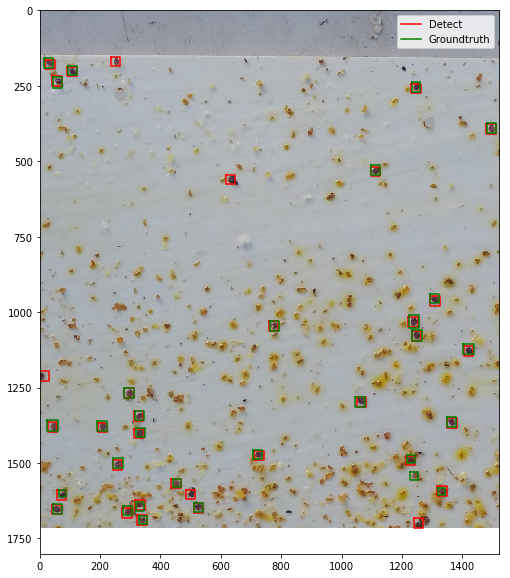

In [960]:
""" Illustrate the performance on some img """
TYPE = 'test'
k = 7
tmp_img = img_dict[TYPE][k]
tmp_gt = gt_dict[TYPE][k]
tmp_gt = [item['bbox'] for item in tmp_gt]

# Visualize 
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(111)

ax.imshow(tmp_img)
tmp_img = remove_black(tmp_img)
filtered_pos_windows = detect_by_svc(tmp_img)

# Compute max IoU score for each detected obj
iou_scores = [np.max([calculate_IoU(detected, gt) for gt in tmp_gt]) \
              if len(tmp_gt) > 0 else 0 \
              for detected in filtered_pos_windows]

for i, window in enumerate(filtered_pos_windows):
    
    if i == 0:
        plot_window(window, ax = ax, c = 'red', label = 'Detect')
    else:
        plot_window(window, ax = ax, c = 'red')
        
for i, window in enumerate(tmp_gt):
    
    if i == 0:
        plot_window(window, ax = ax, c = 'green', label = 'Groundtruth')
    else:
        plot_window(window, ax = ax, c = 'green')
ax.legend()
# fig.savefig('recentered')

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

Due to time limit we have not run the 

## 3.1 Necessary imports

In [2]:
import os

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
from keras.optimizers import SGD, Adam
import random
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Define helper functions

In [4]:
def featureExtractor(image_varroa):
   
    fd, hog_image = hog(image_varroa, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1),block_norm= 'L2', visualize=True, multichannel=True)

    gray = cv2.cvtColor(image_varroa, cv2.COLOR_BGR2GRAY)
    #textures = mt.features.haralick(gray.astype('int'))--> this descriptor doesn't work, can install the packadge

            # take the mean of it and return it
    #ht_mean = textures.mean(axis=0)

    feature = cv2.HuMoments(cv2.moments(gray)).flatten() #7 moments invariant to traslation, rotation and scale..
    return fd,feature

In [5]:
def resize_image(flatten,image,new_height=40,
                 new_width=40,
                 method=cv2.INTER_LANCZOS4):
    
    image=image[flatten[1]:flatten[3],flatten[0]:flatten[2],:]
    dim=(new_width, new_height)        
    new_image = cv2.resize(image,dim,interpolation= method)  
    
    return new_image

NameError: name 'cv2' is not defined

In [ ]:
#function to concatenate all the varroa's boxes obtained from the training images
def concatenate(image,labels,tot_labels,tot_images):
    
    for  values_im,values_lab in zip(image,labels):
        tot_images.append(values_im)
        tot_labels.append(values_lab)
    return (tot_images),tot_labels

In [ ]:
#function that random selects window images from the training images that not present the varroas 
def extract_false_example(image,nb_false_ex,Random=False):
    
    if Random:
        portion_size=random.randint(33, 47)# in case we want to change the window size
    else:
        portion_size=40#select a window size of 40 *40
    image_size = (image.shape[0],image.shape[1])
    images=[]
    
    for i in range(nb_false_ex):#number of the false_example to sample for balance the false and positive classes
        

        x1 = random.randint(0, image_size[0]-portion_size-1)
        y1 = random.randint(0, image_size[1]-portion_size-1)
        
        x2, y2 = x1+portion_size, y1+portion_size

        images.append(image[x1:x2,y1:y2,:])

    return images

In [ ]:
def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig
def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

In [ ]:
#this function is useful to create a sliding window through all the image with a stride of 3
def running_slide_window(image,stepSize,windowSize):
    nb_of_x_steps=np.floor((image.shape[1]-windowSize)/stepSize).astype('int')
    nb_of_y_steps=np.floor((image.shape[0]-windowSize)/stepSize).astype('int')
    for y in range( nb_of_y_steps):
        for x in range( nb_of_x_steps):
            yield ( stepSize*x,stepSize*y,image[stepSize*y:stepSize*y + windowSize, stepSize*x:stepSize*x + windowSize])

In [ ]:
#this function implements the non max suppression algorithm: basically we sort all the predicted labels according 
#to their probability to detect a varroa and we remove the one with lowest probability that reach a 0.1 IoU overlap.

def nonmax_suppression( value, rectangle_values):
    
    
    rectangle_values=sorted(rectangle_values,key=operator.itemgetter(4),reverse=True)
    
    
    if len(rectangle_values)==1:
        return rectangle_values
    
    
    for i,values in enumerate(rectangle_values):
        rect_copy=rectangle_values[i+1:].copy()
        for second_value in rect_copy:
            if verify_intersection(values,second_value) :
                       iou=bb_intersection_over_union(values,second_value)
                       
                        if (iou >=0.1):
                         
                            rectangle_values.remove(second_value )
                            
    return rectangle_values

## 3.2 Start building model

In [ ]:
tot_labels_train=[]
tot_images_train=[]
labels=[]
nb_images=len(varroa_images)


#training data from po samples
for i,values in enumerate((list(varroa_images.values())[0:nb_images])):
    
        flatten =  [item for sublist in values for item in (sublist) ]
        image_nb=int(list(varroa_images.keys())[i])
        image_varroa=[resize_image(image_list[image_nb][pixels[1]:pixels[3],pixels[0]:pixels[2],:])   for pixels in (flatten)]
        labels=[1 for j in range(len(image_varroa))]
    
        
        tot_images_train,tot_labels_train=concatenate(image_varroa,labels,tot_labels_train,(tot_images_train))

#numebr of sample to consider from each negative train classes
nb_of_sample=int(np.floor(len(tot_labels_train)/len(no_varroa_images)))

#training data from negative samples
for i in range(len(no_varroa_images)):
    image_varroa=extract_false_example(image_list[no_varroa_images[i]], nb_of_sample)
    labels=[0 for j in range(len(image_varroa))]
    
    tot_images_train,tot_labels_train=concatenate(image_varroa,labels,tot_labels_train,(tot_images_train))

In [ ]:
#normalization of the training data
train_set=np.asarray(tot_images_train)/255
train_label=keras.utils.to_categorical(tot_labels_train)

our neural networks contains 3 Cnn layers with kernel of 5 and 3 with selu activation function and 3 max pool layer with kernel and stride of 2. The last two layers are 2 fully connected layers. A dropout has been added to avoid overfitting after each layer. The last activation function is a sigmoid because we are dealing with a 2-class problem

In [ ]:
cnnmodel = Sequential()
cnnmodel.add(Conv2D(32, kernel_size = (5,5), activation = 'selu',
            input_shape = (40,40,3)))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

cnnmodel.add(Conv2D(64, (3, 3), activation='selu'))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

cnnmodel.add(Conv2D(64, kernel_size = (3,3), activation = 'selu'))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
cnnmodel.add(Dropout(0.25))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(200, activation='selu'))
cnnmodel.add(Dropout(0.2))
cnnmodel.add(Dense(2, activation='sigmoid'))


The optimizer is Adam and the loss function is the binary cross entropy , we decide a batch size of 300 and a validation set equal to the 0.3% of the total data. 15 epochs are considered to train the model.

In [ ]:
adam = Adam()
cnnmodel.compile(loss = 'binary_crossentropy',
             optimizer = adam,
             metrics = ['accuracy'])
cnnhistory = cnnmodel.fit(train_set, train_label,
         epochs = 15,
         batch_size = 500,
         validation_split = .3,shuffle=True)

In [ ]:
plot_history(cnnhistory, 'Convolutional NN')
print("Maximum accuracy: {}".format(np.max(cnnhistory.history['val_acc'])))

The model is trained considering a sliding window of dimensions 40*40 that slides all the image with a stride set to 10. A non-max suppression is applied to remove all the overlapping boxeswith IoU of 0.1. A big brawback of this method concerns the computational cost. We didn't try to merge different size of sliding window.


In this section we made our predictions on a random image of the test set. As said before, this method is really computational inefficient, just thinking that it takes about 10min to run this code on just one image (about 2000*2000 pixels)! Before calling the algorithm of non-max suppression, another threshold is established of 0.99 to remove the predictions of lower probability

In [ ]:
#look at the result:
import operator
rectangle_values={}
size_window=40

for i,images in enumerate(image_list[130:131]):# images as test set
    rectangle_values[str(i)]=[]
    #images=cv2.resize(images,dim,interpolation=cv2.INTER_LANCZOS4)
    
    for (x,y,window) in running_slide_window(images,10,size_window):#3 is the stride
        window=np.expand_dims(window,axis=0)
        pred=cnnmodel.predict_proba(window/255)
        
       
        #first thresholding
        if (pred[0][1]>0.999) :
         
            rectangle_values[str(i)].append([x,y,x+size_window,y+size_window,pred[0][1]])
            rectangle_values[str(i)]=nonmax_suppression(pred[0][1],rectangle_values[str(i)])

In [ ]:
# 2 method = only cnn no fc for fast computation
cnnmodel = Sequential()
cnnmodel.add(Conv2D(32, kernel_size = (5,5), activation = 'relu',
            input_shape = (None,None,3)))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
cnnmodel.add(Conv2D(64, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
cnnmodel.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
cnnmodel.add(Dropout(0.25))

cnnmodel.add(Conv2D(576, kernel_size = (3,3), activation = 'relu'))
cnnmodel.add(Dropout(0.25))
cnnmodel.add(Conv2D(100, kernel_size = (1,1), activation = 'relu'))
cnnmodel.add(Conv2D(2, kernel_size = (1,1), activation = 'sigmoid'))

In [ ]:
adam = Adam()
cnnmodel.compile(loss = 'binary_crossentropy',
             optimizer = adam,
             metrics = ['accuracy'])
cnnhistory = cnnmodel.fit(train_set, np.expand_dims(np.expand_dims(train_label,axis=1),axis=2),
         epochs = 10,
         batch_size = 500,
         validation_split = .3)

In [ ]:
plot_history(cnnhistory, 'Convolutional NN')
print("Maximum accuracy: {}".format(np.max(cnnhistory.history['val_acc'])))

In [ ]:
#this function helps to find the stride that it's applied to each image when is trained by our model:
def finding_stride(pred,size_window,images):
    
        
    return np.floor((images.shape[1]-size_window)/(pred.shape[0]-1))


After training the model, let's see how it is performing on the training set, 'image_list' contains all the 800 input images, but to make the computation more fast we just consider the first 50 !

In [ ]:
cnn_rectangle_train_values={}
for k,images in enumerate(image_list[0:50]):
    cnn_rectangle_train_values[str(k)]=[]
    images=np.expand_dims(images,axis=0)
    pred=cnnmodel.predict_proba(images/255)
    pred=pred.squeeze()
    pred=pred[:,:,1]
    stride=finding_stride(pred,size_window,images)
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            if pred[i,j]>0.999: # first filter
                filter_size=[(j)*stride,(i)*stride,(j)*stride+size_window,(i)*stride+size_window,pred[i,j]]
                cnn_rectangle_train_values[str(k)].append(filter_size )
                cnn_rectangle_train_values[str(k)]=nonmax_suppression(pred[i,j],cnn_rectangle_train_values[str(k)])


now let's compare the results with the labels from the ground_truth dictionary and save into another dictionary (cnn_rectangle_train_fp_values) all the false positive for retrain our network!!!

In [ ]:
threshold=0.3
tp,fp,fn=0,0,0
cnn_rectangle_train_fp_values={}


for i in range( len(list(ground_truth.keys())[0:50])):
    print('nb of image:{}'.format(i))
    df=pd.DataFrame(index=range(len(ground_truth[str(i)][0])), columns=range(len(cnn_rectangle_train_values[str(i)])))
    for  k,real_value in enumerate(ground_truth[str(i)][0]):

        for j,prediction in enumerate(cnn_rectangle_train_values[str(i)]):#for each prediction let's calculate the IoU respect to each target

                if verify_intersection(real_value,prediction) :
                       iou=bb_intersection_over_union(prediction,real_value)
                        df.loc[k,j]=iou
                else :

                    df.loc[k,j]=0
    #counting the number of true positive, false postive and false negative               
    
    
    fp+=np.sum(df.max(axis=0)<threshold)
    values_fp=df.loc[:,df.max(axis=0)<threshold].columns.values
    cnn_rectangle_train_fp_values[str(i)]=[]
    for p in values_fp:
    
        cnn_rectangle_train_fp_values[str(i)].append(cnn_rectangle_train_values[str(i)][p])

create a new training set made of the false positive detection and assign to them a zero label :

In [ ]:
tot_labels_train_fp=[]
tot_images_train_fp=[]
labels=[]



#training data from po samples
for i,values in enumerate((cnn_rectangle_train_fp_values.values())):
    
        flatten =  [sublist for sublist in values ]
        
        image_varroa=[resize_image(image_list[i][int(pixels[1]):int(pixels[3]),int(pixels[0]):int(pixels[2]),:])   for (pixels) in (flatten)]
        labels=[0 for j in range(len(image_varroa))]
    
        
        tot_images_train_fp,tot_labels_train_fp=concatenate(image_varroa,labels,tot_labels_train_fp,tot_images_train_fp)


nb_of_fp_sample=len(tot_labels_train_fp)

let's still consider the principle of class-balance and take the same amount of positive classes:



In [ ]:
for i,values in enumerate((list(varroa_images.values())[0:100])):
    
        flatten =  [item for sublist in values for item in (sublist) ]
        image_nb=int(list(varroa_images.keys())[i])
        image_varroa=[resize_image(image_list[image_nb][pixels[1]:pixels[3],pixels[0]:pixels[2],:])   for pixels in (flatten)]
        labels=[1 for j in range(len(image_varroa))]
    
        
        tot_images_train_fp,tot_labels_train_fp=concatenate(image_varroa,labels,tot_labels_train_fp,tot_images_train_fp)

In [ ]:
#normalization of the training data
train_set=np.asarray(tot_images_train_fp)/255
train_label=keras.utils.to_categorical(tot_labels_train_fp)

In [ ]:
adam = Adam()
cnnmodel.compile(loss = 'binary_crossentropy',
             optimizer = adam,
             metrics = ['accuracy'])
cnnhistory = cnnmodel.fit(train_set, np.expand_dims(np.expand_dims(train_label,axis=1),axis=2),
         epochs = 20,
         batch_size = 100,
         validation_split = .3,shuffle=True)

In [ ]:
cnn_rectangle_values={}

for k,images in enumerate(image_test_list):
    cnn_rectangle_values[str(k)]=[]
    images=np.expand_dims(images,axis=0)
    pred=cnnmodel.predict_proba(images/255)
    pred=pred.squeeze()
    pred=pred[:,:,1]
    stride=finding_stride(pred,size_window,images)
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            if pred[i,j]>0.999: # first filter
                filter_size=[(j)*stride,(i)*stride,(j)*stride+size_window,(i)*stride+size_window,pred[i,j]]
                cnn_rectangle_values[str(k)].append(filter_size )
                cnn_rectangle_values[str(k)]=nonmax_suppression(pred[i,j],cnn_rectangle_values[str(k)])

In [ ]:
threshold=0.3
tp,fp,fn=0,0,0

#run for the test_images
for i in range( len(ground_test_truth.keys())):
    print('nb of image:{}'.format(i))
    df=pd.DataFrame(index=range(len(ground_test_truth[str(i)][0])), columns=range(len(cnn_rectangle_values[str(i)])))
    for  k,real_value in enumerate(ground_test_truth[str(i)][0]):

        for j,prediction in enumerate(cnn_rectangle_values[str(i)]):#for each prediction let's calculate the IoU respect to each target

                if verify_intersection(real_value,prediction) :
                       iou=bb_intersection_over_union(prediction,real_value)
                       df.loc[k,j]=iou
                else :

                    df.loc[k,j]=0
     #counting the number of true positive, false postive nd false negative               
    tp+=np.sum(df.max(axis=1)>=threshold)
    fp+=np.sum(df.max(axis=0)<threshold)
    fn+=np.sum(df.max(axis=1)<threshold)


In [ ]:
print('true positive:{} ,false positive:{} ,false negative:{}'.format(tp,fp,fn))


In [ ]:
print('precision',tp/(tp+fp))
print('recall',tp/(tp+fn))
print('F1',( 2*tp/(tp+fn) * tp/(tp+fp) )/(tp/(tp+fp)+tp/(tp+fn)))


## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [919]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)